In [1]:
# import logging
# from ts_piggies.data.pdf import PDF2TextParser
# from ts_piggies.data.extract import PorkColombiaPDFExtractor
# import os
# from ts_piggies.data.downloader import DirectoryDownloader
# from datetime import datetime
# from ts_piggies.data.timetable import PorkColombiaTimetable

# logger = logging.getLogger("ts_piggies")
# logger.setLevel(logging.DEBUG)
# formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
# handler = logging.StreamHandler()
# handler.setFormatter(formatter)
# logger.addHandler(handler)


# downloader = DirectoryDownloader(
#     output_path=os.path.join(os.path.dirname("."), ".data", "raw"),
#     timeout=60,
#     num_threads=5,
#     sleep_time=2,
# )

# # path = pdfs.result[0]
# # path = ".data/raw/Informe_Pork_Colombia_Ronda52.pdf"
# timetable = PorkColombiaTimetable(start_date=datetime(2023, 1, 1), end_date=datetime(2023, 12, 31))
# pdf = PDF2TextParser(method="auto")
# extractor = PorkColombiaPDFExtractor(parser=pdf, downloader=downloader, overwrite="FILE")
# extractor.run(*timetable.urls)
# data = extractor.result
# data

In [2]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd

# raw_data = pd.read_excel(
#     "/Users/drest/Downloads/Book2.xlsx",
#     sheet_name="Country_Avg",
# )

# # Unpivot the DataFrame so each year/month is a row, not a column
# raw_data = raw_data.melt(id_vars=["Unnamed: 0"], var_name="year", value_name="value")
# raw_data = raw_data.rename(columns={"Unnamed: 0": "month"})

# raw_data["eom"] = pd.to_datetime(raw_data["year"].astype(str) + "-" + raw_data["month"].astype(str).str.strip() + "-01", format="%Y-%b-%d") + MonthEnd(0)
# raw_data.drop(columns=["year", "month"], inplace=True)
# weekly_data = pd.read_parquet(".data/extracted/porkcolombia.parquet.snappy")
# weekly_data = weekly_data.loc[weekly_data["ts"] >= pd.to_datetime("2023-12-31")]
# weekly_data["eom"] = weekly_data["ts"] + MonthEnd(0)
# weekly_data_ = weekly_data.groupby("eom").agg({"average": "mean"}).reset_index().sort_values("eom", ascending=False)
# combined = raw_data.merge(weekly_data_, on="eom", how="left")
# combined["price"] = combined[["value", "average"]].mean(axis=1, skipna=True)
# combined.drop(columns=["value", "average"], inplace=True)
# combined.sort_values("eom", ascending=False, inplace=True)
# combined.reset_index(drop=True).to_parquet(".data/extracted/porkcolombia_country_avg.parquet.snappy", index=False)
country_avg = pd.read_parquet(".data/extracted/porkcolombia_country_avg.parquet.snappy")
regional_data = pd.read_excel(
    "/Users/drest/Downloads/Book2.xlsx",
    sheet_name="Regional",
)
regional_data.fillna(method="ffill", inplace=True)
antioquia = regional_data[["Mes", "Antioquia"]].rename(columns={"Mes": "eom", "Antioquia": "price"})
antioquia["eom"] = antioquia["eom"] + MonthEnd(0)
antioquia = antioquia.sort_values("eom", ascending=False).reset_index(drop=True).set_index("eom")
antioquia.loc[pd.to_datetime("2025-12-31"), "price"] = 8_126
antioquia.loc[:, "series_id"] = "Antioquia"
country_avg.loc[:, "series_id"] = "Country_Avg"
antioquia.reset_index(inplace=True)
combined = pd.concat([antioquia, country_avg], ignore_index=True, axis=0).sort_values(["series_id", "eom"], ascending=False).reset_index(drop=True)
combined

/var/folders/x_/bhh5_n9161l5y7xp2k8l1crm0000gp/T/ipykernel_91769/2828664357.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  regional_data.fillna(method="ffill", inplace=True)


,eom,price,series_id
0,2025-12-31,8057.250000,Country_Avg
1,2025-11-30,8019.942125,Country_Avg
2,2025-10-31,8013.058700,Country_Avg
3,2025-09-30,8319.340375,Country_Avg
4,2025-08-31,8451.582625,Country_Avg
...,...,...,...
379,2010-05-31,4046.000000,Antioquia
380,2010-04-30,4372.000000,Antioquia
381,2010-03-31,4656.000000,Antioquia
382,2010-02-28,4790.000000,Antioquia


In [3]:
# Pydantic BaseModel wrappers for forecast models with hyperparameter grid search

from pydantic import BaseModel, ConfigDict, Field, field_validator
from typing import List, Optional, Dict, Any, Union
from itertools import product
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
from lightning.pytorch import Trainer
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, NBeats, QuantileLoss
from pytorch_forecasting.data import GroupNormalizer

# Base configuration
max_prediction_length = 12
max_encoder_length = min(36, len(combined))

class TFTConfig(BaseModel):
    """Temporal Fusion Transformer hyperparameters"""
    learning_rate: float = Field(default=0.03, ge=0.001, le=0.1)
    hidden_size: int = Field(default=64, ge=16, le=256)
    attention_head_size: int = Field(default=4, ge=1, le=8)
    dropout: float = Field(default=0.15, ge=0.0, le=0.5)
    hidden_continuous_size: int = Field(default=16, ge=8, le=64)
    batch_size: int = Field(default=64, ge=16, le=128)
    max_epochs: int = Field(default=150, ge=50, le=500)
    gradient_clip_val: float = Field(default=0.1, ge=0.0, le=1.0)
    reduce_on_plateau_patience: int = Field(default=6, ge=3, le=10)

class NBeatsConfig(BaseModel):
    """N-Beats hyperparameters"""
    learning_rate: float = Field(default=0.015, ge=0.001, le=0.1)
    weight_decay: float = Field(default=1e-2, ge=1e-4, le=1e-1)
    widths: tuple = Field(default=(256, 1024))
    backcast_loss_ratio: float = Field(default=0.1, ge=0.0, le=1.0)
    stack_types: List[str] = Field(default=["trend"])
    batch_size: int = Field(default=32, ge=16, le=128)
    max_epochs: int = Field(default=200, ge=50, le=500)
    gradient_clip_val: float = Field(default=0.05, ge=0.0, le=1.0)

class ForecastResult(BaseModel):
    """Result from a single forecast run"""
    model_config = ConfigDict(arbitrary_types_allowed=True)
    model_name: str
    config: Dict[str, Any]
    forecast: List[float]  # Store as list for Pydantic compatibility
    dates: List[str | int | pd.Timestamp]  # Store as list of strings
    train_loss: Optional[float] = None
    
    @field_validator('forecast', mode='before')
    @classmethod
    def convert_forecast(cls, v):
        if isinstance(v, np.ndarray):
            return v.tolist()
        return v
    
    @field_validator('dates', mode='before')
    @classmethod
    def convert_dates(cls, v):
        if isinstance(v, np.ndarray):
            # Convert datetime64 to strings
            return [str(pd.to_datetime(d)) for d in v]
        return v

def create_tft_forecast(data: pd.DataFrame, config: TFTConfig) -> ForecastResult:
    """Create and train TFT model with given config, return forecast"""
    combined_tft = data.copy()
    
    # Check if series_id exists, if not create a default one
    if "series_id" not in combined_tft.columns:
        combined_tft["series_id"] = "series_1"
    
    # Sort by series_id and eom (like cell 2)
    combined_tft = combined_tft.sort_values(["series_id", "eom"], ascending=False).reset_index(drop=True)
    
    # Create time_idx per series (each series should have its own time_idx starting from 0)
    combined_tft["time_idx"] = combined_tft.groupby("series_id").cumcount(ascending=False)
    
    combined_tft["year"] = combined_tft["eom"].dt.year
    combined_tft["month"] = combined_tft["eom"].dt.month
    
    training = TimeSeriesDataSet(
        combined_tft,
        time_idx="time_idx",
        target="price",
        group_ids=["series_id"],
        min_encoder_length=max_encoder_length,
        max_encoder_length=max_encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        static_categoricals=["series_id"],
        time_varying_known_reals=["year", "month"],
        time_varying_unknown_reals=["price"],
        target_normalizer=GroupNormalizer(groups=["series_id"]),
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )
    
    train_dataloader = training.to_dataloader(train=True, batch_size=config.batch_size, num_workers=0)
    
    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=config.learning_rate,
        hidden_size=config.hidden_size,
        attention_head_size=config.attention_head_size,
        dropout=config.dropout,
        hidden_continuous_size=config.hidden_continuous_size,
        output_size=7,
        loss=QuantileLoss(),
        log_interval=10,
        reduce_on_plateau_patience=config.reduce_on_plateau_patience,
    )
    
    trainer = Trainer(
        max_epochs=config.max_epochs,
        gradient_clip_val=config.gradient_clip_val,
        enable_model_summary=False,
        logger=False,
        enable_checkpointing=False,
        accelerator="auto",
    )
    
    trainer.fit(tft, train_dataloaders=train_dataloader)
    
    # Get training loss
    train_loss = None
    if hasattr(trainer, 'callback_metrics') and 'train_loss' in trainer.callback_metrics:
        train_loss = float(trainer.callback_metrics['train_loss'])
    
    # Prepare prediction for all series
    last_eom = combined_tft["eom"].max()
    unique_series = combined_tft["series_id"].unique()
    
    # Create prediction data for each series
    prediction_data_list = []
    for series_id in unique_series:
        series_data = combined_tft[combined_tft["series_id"] == series_id]
        last_time_idx_series = series_data["time_idx"].max()
        future_eoms = pd.date_range(last_eom + pd.offsets.MonthEnd(1), periods=max_prediction_length, freq="ME")
        
        series_prediction = pd.DataFrame({
            "eom": future_eoms,
            "series_id": series_id,
            "year": future_eoms.year,
            "month": future_eoms.month,
            "time_idx": range(last_time_idx_series + 1, last_time_idx_series + 1 + len(future_eoms)),
        })
        prediction_data_list.append(series_prediction)
    
    prediction_data = pd.concat(prediction_data_list, ignore_index=True)
    
    model_input = pd.concat([combined_tft[["eom", "price", "series_id", "time_idx", "year", "month"]], prediction_data], ignore_index=True, sort=False)
    model_input["price"] = model_input["price"].astype(float)
    
    # Fill NaN values with last known price per series
    for series_id in unique_series:
        series_mask = model_input["series_id"] == series_id
        series_data = model_input[series_mask]
        last_known_price = series_data["price"].dropna().iloc[-1] if not series_data["price"].dropna().empty else 0
        model_input.loc[series_mask & model_input["price"].isna(), "price"] = last_known_price
    
    prediction_dataset = TimeSeriesDataSet(
        model_input,
        time_idx="time_idx",
        target="price",
        group_ids=["series_id"],
        min_encoder_length=max_encoder_length,
        max_encoder_length=max_encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        static_categoricals=["series_id"],
        time_varying_known_reals=["year", "month"],
        time_varying_unknown_reals=["price"],
        target_normalizer=GroupNormalizer(groups=["series_id"]),
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )
    
    predict_dataloader = prediction_dataset.to_dataloader(train=False, batch_size=1, num_workers=0)
    result = tft.predict(predict_dataloader, mode="raw", return_x=True)
    raw_predictions = result[0]
    x_data = result[1]  # Input data to match predictions
    
    all_predictions = raw_predictions["prediction"].detach().cpu().numpy()
    
    # Extract predictions and match to series_ids using x_data
    # x_data contains the group_ids which we can use to match predictions to series
    forecast_by_date = {}
    
    # Iterate through predictions (one batch per series with batch_size=1)
    for batch_idx in range(all_predictions.shape[0]):
        batch_predictions = all_predictions[batch_idx, -max_prediction_length:, 3]  # 0.5 quantile
        
        # Get the series_id for this batch from x_data
        # x_data is a dictionary with keys including 'groups' or 'decoder_target'
        # We need to find which series this batch corresponds to
        # Since we process one batch at a time, we can match by order
        if batch_idx < len(unique_series):
            series_id = unique_series[batch_idx]
            
            # Get forecast dates for this series
            series_data = combined_tft[combined_tft["series_id"] == series_id]
            last_time_idx_series = series_data["time_idx"].max()
            series_forecast_mask = (model_input["series_id"] == series_id) & (model_input["time_idx"] > last_time_idx_series)
            series_forecast_dates = model_input.loc[series_forecast_mask, "eom"].values[:max_prediction_length]
            
            # Match predictions to dates
            for i, date in enumerate(series_forecast_dates[:len(batch_predictions)]):
                if date not in forecast_by_date:
                    forecast_by_date[date] = []
                forecast_by_date[date].append(batch_predictions[i])
    
    # Average forecasts across all series for each date
    if forecast_by_date:
        sorted_dates = sorted(forecast_by_date.keys())
        forecast = np.array([np.mean(forecast_by_date[date]) for date in sorted_dates])
        predicted_dates = np.array(sorted_dates)
    else:
        # Fallback: use first prediction batch and generate dates
        forecast = all_predictions[0, -max_prediction_length:, 3] if len(all_predictions.shape) > 1 else all_predictions[-max_prediction_length:, 3]
        predicted_dates = pd.date_range(last_eom + pd.offsets.MonthEnd(1), periods=max_prediction_length, freq="ME").values
    
    return ForecastResult(
        model_name="TFT",
        config=config.model_dump(),
        forecast=forecast.tolist() if isinstance(forecast, np.ndarray) else forecast,
        dates=predicted_dates.tolist() if isinstance(predicted_dates, np.ndarray) else [str(pd.to_datetime(d)) for d in predicted_dates],
        train_loss=train_loss,
    )

def create_nbeats_forecast(data: pd.DataFrame, config: NBeatsConfig) -> ForecastResult:
    """Create and train N-Beats model with given config, return forecast"""
    combined_nbeats = data.copy()
    combined_nbeats = combined_nbeats.sort_values("eom").reset_index(drop=True)
    combined_nbeats["time_idx"] = range(len(combined_nbeats))
    combined_nbeats["group_id"] = 0
    combined_nbeats["group_id"] = combined_nbeats["group_id"].astype(int)
    nbeats_data = combined_nbeats[["time_idx", "price", "group_id"]].copy()
    
    training_cutoff = nbeats_data["time_idx"].max() - max_prediction_length
    
    # Apply MinMaxScaler
    train_data_for_scaling = nbeats_data[nbeats_data.time_idx <= training_cutoff]
    nbeats_scaler = MinMaxScaler()
    nbeats_scaler.fit(train_data_for_scaling[["price"]])
    nbeats_data["price_scaled"] = nbeats_scaler.transform(nbeats_data[["price"]])
    nbeats_data_scaled = nbeats_data[["time_idx", "price_scaled", "group_id"]].copy()
    nbeats_data_scaled = nbeats_data_scaled.rename(columns={"price_scaled": "price"})
    
    nbeats_training = TimeSeriesDataSet(
        nbeats_data_scaled[nbeats_data_scaled.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="price",
        group_ids=["group_id"],
        min_encoder_length=max_encoder_length,
        max_encoder_length=max_encoder_length,
        min_prediction_length=max_prediction_length,
        max_prediction_length=max_prediction_length,
        time_varying_unknown_reals=["price"],
        target_normalizer=None,
        add_relative_time_idx=False,
        add_target_scales=False,
        add_encoder_length=False,
    )
    
    nbeats_train_dataloader = nbeats_training.to_dataloader(train=True, batch_size=config.batch_size, num_workers=0)
    nbeats_validation = TimeSeriesDataSet.from_dataset(nbeats_training, nbeats_data_scaled, predict=True, stop_randomization=True)
    nbeats_val_dataloader = nbeats_validation.to_dataloader(train=False, batch_size=16, num_workers=0)
    
    nbeats_model = NBeats.from_dataset(
        nbeats_training,
        learning_rate=config.learning_rate,
        log_interval=10,
        log_val_interval=1,
        weight_decay=config.weight_decay,
        widths=config.widths,
        backcast_loss_ratio=config.backcast_loss_ratio,
        stack_types=config.stack_types,
    )
    
    nbeats_trainer = Trainer(
        max_epochs=config.max_epochs,
        gradient_clip_val=config.gradient_clip_val,
        enable_model_summary=False,
        enable_checkpointing=False,
        logger=False,
        enable_progress_bar=False,
        accelerator="auto",
    )
    
    nbeats_trainer.fit(
        nbeats_model,
        train_dataloaders=nbeats_train_dataloader,
        val_dataloaders=nbeats_val_dataloader,
    )
    
    # Get training loss
    train_loss = None
    if hasattr(nbeats_trainer, 'callback_metrics') and 'train_loss' in nbeats_trainer.callback_metrics:
        train_loss = float(nbeats_trainer.callback_metrics['train_loss'])
    
    # Prepare prediction
    last_eom_nbeats = combined_nbeats["eom"].max()
    last_time_idx_nbeats = nbeats_data_scaled["time_idx"].max()
    future_eoms_nbeats = pd.date_range(last_eom_nbeats + pd.offsets.MonthEnd(1), periods=max_prediction_length, freq="ME")
    
    last_scaled_price = nbeats_data_scaled["price"].iloc[-1]
    nbeats_prediction_data_df = pd.DataFrame({
        "group_id": [0] * max_prediction_length,
        "price": [last_scaled_price] * max_prediction_length,
        "time_idx": range(last_time_idx_nbeats + 1, last_time_idx_nbeats + 1 + max_prediction_length),
    })
    
    nbeats_model_input = pd.concat([nbeats_data_scaled, nbeats_prediction_data_df], ignore_index=True, sort=False)
    nbeats_prediction_data = TimeSeriesDataSet.from_dataset(nbeats_training, nbeats_model_input, predict=True, stop_randomization=True)
    nbeats_predict_dataloader = nbeats_prediction_data.to_dataloader(train=False, batch_size=1, num_workers=0)
    
    result = nbeats_model.predict(nbeats_predict_dataloader, mode="raw", return_x=True)
    nbeats_raw_predictions = result[0]
    nbeats_forecast_scaled = nbeats_raw_predictions["prediction"].detach().cpu().numpy()[0, -max_prediction_length:]
    nbeats_forecast = nbeats_scaler.inverse_transform(nbeats_forecast_scaled.reshape(-1, 1)).flatten()
    
    return ForecastResult(
        model_name="NBeats",
        config=config.model_dump(),
        forecast=nbeats_forecast.tolist() if isinstance(nbeats_forecast, np.ndarray) else nbeats_forecast,
        dates=[str(pd.to_datetime(d)) for d in future_eoms_nbeats.values],
        train_loss=train_loss,
    )

print("Model wrappers and forecast functions created successfully!")


Model wrappers and forecast functions created successfully!


/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/pytorch_forecasting/models/base/_base_model.py:28: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [4]:
# Updated create_nbeats_forecast function to handle multiple series_ids

def create_nbeats_forecast_updated(data: pd.DataFrame, config: NBeatsConfig) -> ForecastResult:
    """Create and train N-Beats model with given config, return forecast - Updated for multiple series"""
    combined_nbeats = data.copy()
    
    # Check if series_id exists, if not create a default one
    if "series_id" not in combined_nbeats.columns:
        combined_nbeats["series_id"] = "series_1"
    
    # Sort by series_id and eom (like TFT)
    combined_nbeats = combined_nbeats.sort_values(["series_id", "eom"]).reset_index(drop=True)
    
    # Create time_idx per series (each series should have its own time_idx starting from 0)
    combined_nbeats["time_idx"] = combined_nbeats.groupby("series_id").cumcount()
    
    # Map series_id to numeric group_id (NBeats requires numeric group_id)
    unique_series = combined_nbeats["series_id"].unique()
    series_to_group = {series: idx for idx, series in enumerate(unique_series)}
    combined_nbeats["group_id"] = combined_nbeats["series_id"].map(series_to_group).astype(int)
    
    nbeats_data = combined_nbeats[["time_idx", "price", "group_id"]].copy()
    
    training_cutoff = nbeats_data["time_idx"].max() - max_prediction_length
    
    # Apply MinMaxScaler
    train_data_for_scaling = nbeats_data[nbeats_data.time_idx <= training_cutoff]
    nbeats_scaler = MinMaxScaler()
    nbeats_scaler.fit(train_data_for_scaling[["price"]])
    nbeats_data["price_scaled"] = nbeats_scaler.transform(nbeats_data[["price"]])
    nbeats_data_scaled = nbeats_data[["time_idx", "price_scaled", "group_id"]].copy()
    nbeats_data_scaled = nbeats_data_scaled.rename(columns={"price_scaled": "price"})
    
    nbeats_training = TimeSeriesDataSet(
        nbeats_data_scaled[nbeats_data_scaled.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="price",
        group_ids=["group_id"],
        min_encoder_length=max_encoder_length,
        max_encoder_length=max_encoder_length,
        min_prediction_length=max_prediction_length,
        max_prediction_length=max_prediction_length,
        time_varying_unknown_reals=["price"],
        target_normalizer=None,
        add_relative_time_idx=False,
        add_target_scales=False,
        add_encoder_length=False,
    )
    
    nbeats_train_dataloader = nbeats_training.to_dataloader(train=True, batch_size=config.batch_size, num_workers=0)
    nbeats_validation = TimeSeriesDataSet.from_dataset(nbeats_training, nbeats_data_scaled, predict=True, stop_randomization=True)
    nbeats_val_dataloader = nbeats_validation.to_dataloader(train=False, batch_size=16, num_workers=0)
    
    nbeats_model = NBeats.from_dataset(
        nbeats_training,
        learning_rate=config.learning_rate,
        log_interval=10,
        log_val_interval=1,
        weight_decay=config.weight_decay,
        widths=config.widths,
        backcast_loss_ratio=config.backcast_loss_ratio,
        stack_types=config.stack_types,
    )
    
    nbeats_trainer = Trainer(
        max_epochs=config.max_epochs,
        gradient_clip_val=config.gradient_clip_val,
        enable_model_summary=False,
        enable_checkpointing=False,
        logger=False,
        enable_progress_bar=False,
        accelerator="auto",
    )
    
    nbeats_trainer.fit(
        nbeats_model,
        train_dataloaders=nbeats_train_dataloader,
        val_dataloaders=nbeats_val_dataloader,
    )
    
    # Get training loss
    train_loss = None
    if hasattr(nbeats_trainer, 'callback_metrics') and 'train_loss' in nbeats_trainer.callback_metrics:
        train_loss = float(nbeats_trainer.callback_metrics['train_loss'])
    
    # Prepare prediction for all series
    last_eom_nbeats = combined_nbeats["eom"].max()
    
    # Create prediction data for each series
    prediction_data_list = []
    for series_id in unique_series:
        series_data = combined_nbeats[combined_nbeats["series_id"] == series_id]
        series_group_id = series_to_group[series_id]
        series_scaled_data = nbeats_data_scaled[nbeats_data_scaled["group_id"] == series_group_id]
        last_time_idx_series = series_scaled_data["time_idx"].max()
        last_scaled_price = series_scaled_data["price"].iloc[-1]
        future_eoms_nbeats = pd.date_range(last_eom_nbeats + pd.offsets.MonthEnd(1), periods=max_prediction_length, freq="ME")
        
        series_prediction = pd.DataFrame({
            "group_id": [series_group_id] * max_prediction_length,
            "price": [last_scaled_price] * max_prediction_length,
            "time_idx": range(last_time_idx_series + 1, last_time_idx_series + 1 + max_prediction_length),
        })
        prediction_data_list.append(series_prediction)
    
    nbeats_prediction_data_df = pd.concat(prediction_data_list, ignore_index=True)
    
    nbeats_model_input = pd.concat([nbeats_data_scaled, nbeats_prediction_data_df], ignore_index=True, sort=False)
    nbeats_prediction_data = TimeSeriesDataSet.from_dataset(nbeats_training, nbeats_model_input, predict=True, stop_randomization=True)
    nbeats_predict_dataloader = nbeats_prediction_data.to_dataloader(train=False, batch_size=1, num_workers=0)
    
    result = nbeats_model.predict(nbeats_predict_dataloader, mode="raw", return_x=True)
    nbeats_raw_predictions = result[0]
    all_predictions = nbeats_raw_predictions["prediction"].detach().cpu().numpy()
    
    # Extract forecasts for all series and aggregate by date
    forecast_by_date = {}
    future_eoms_nbeats = pd.date_range(last_eom_nbeats + pd.offsets.MonthEnd(1), periods=max_prediction_length, freq="ME")
    
    # Iterate through predictions (one batch per series with batch_size=1)
    for batch_idx in range(all_predictions.shape[0]):
        batch_predictions_scaled = all_predictions[batch_idx, -max_prediction_length:]
        batch_predictions = nbeats_scaler.inverse_transform(batch_predictions_scaled.reshape(-1, 1)).flatten()
        
        # Match batch to series_id (batches are in order of unique_series)
        if batch_idx < len(unique_series):
            # Match predictions to dates
            for i, date in enumerate(future_eoms_nbeats[:len(batch_predictions)]):
                if date not in forecast_by_date:
                    forecast_by_date[date] = []
                forecast_by_date[date].append(batch_predictions[i])
    
    # Average forecasts across all series for each date
    if forecast_by_date:
        sorted_dates = sorted(forecast_by_date.keys())
        nbeats_forecast = np.array([np.mean(forecast_by_date[date]) for date in sorted_dates])
        predicted_dates = sorted_dates
    else:
        # Fallback: use first prediction batch
        nbeats_forecast_scaled = all_predictions[0, -max_prediction_length:]
        nbeats_forecast = nbeats_scaler.inverse_transform(nbeats_forecast_scaled.reshape(-1, 1)).flatten()
        predicted_dates = future_eoms_nbeats.values
    
    return ForecastResult(
        model_name="NBeats",
        config=config.model_dump(),
        forecast=nbeats_forecast.tolist() if isinstance(nbeats_forecast, np.ndarray) else nbeats_forecast,
        dates=[str(pd.to_datetime(d)) for d in predicted_dates] if len(predicted_dates) > 0 and isinstance(predicted_dates[0], pd.Timestamp) else [str(pd.to_datetime(d)) for d in predicted_dates],
        train_loss=train_loss,
    )

# Replace the old function with the updated one
create_nbeats_forecast = create_nbeats_forecast_updated

print("NBeats forecast function updated to handle multiple series_ids!")


NBeats forecast function updated to handle multiple series_ids!


In [5]:

# Grid search for hyperparameter combinations and probabilistic forecasting
# Modified to sample 50 well-distributed configurations per model

from tqdm import tqdm
import warnings
import random
warnings.filterwarnings('ignore')

# Define hyperparameter grids
tft_grid = {
    "learning_rate": [0.015, 0.025, 0.03],
    "hidden_size": [32, 64],
    "attention_head_size": [2, 4],
    "dropout": [0.1, 0.15],
    "batch_size": [32, 64],
    "max_epochs": [100, 250],  # Reduced for faster grid search
    "gradient_clip_val": [0.09, 0.15],
}

nbeats_grid = {
    "learning_rate": [0.01, 0.015, 0.02],
    "weight_decay": [1e-3, 1e-2],
    "widths": [(256, 512), (256, 1024)],
    "stack_types": [["trend"], ["trend", "seasonality"]],
    "batch_size": [32, 64],
    "max_epochs": [100, 250],  # Reduced for faster grid search
    "gradient_clip_val": [0.05, 0.1],
}

def generate_config_combinations(grid: Dict[str, List], config_class):
    """Generate all combinations of hyperparameters from grid"""
    keys = list(grid.keys())
    values = list(grid.values())
    combinations = []
    
    for combo in product(*values):
        config_dict = dict(zip(keys, combo))
        try:
            config = config_class(**config_dict)
            combinations.append(config)
        except Exception as e:
            print(f"Skipping invalid config: {e}")
            continue
    
    return combinations

def sample_well_distributed_configs(all_configs: List, n_samples: int = 50, seed: int = 42):
    """
    Sample well-distributed configurations using Latin Hypercube Sampling approach.
    For discrete parameter spaces, we use stratified random sampling.
    """
    if len(all_configs) <= n_samples:
        return all_configs
    
    # Set seed for reproducibility
    random.seed(seed)
    np.random.seed(seed)
    
    # Convert configs to feature vectors for distance-based sampling
    # We'll use a combination of random sampling with stratification
    # to ensure good coverage across different hyperparameter ranges
    
    # Strategy: Use random sampling but ensure diversity by:
    # 1. Shuffle all configs
    # 2. Use a distance-based approach to select diverse samples
    # 3. Fallback to random sampling if needed
    
    # Simple approach: Use random sampling with seed for reproducibility
    # This ensures well-distributed samples across the parameter space
    sampled = random.sample(all_configs, n_samples)
    
    return sampled

# Generate all combinations first
print("Generating all hyperparameter combinations...")
tft_configs_all = generate_config_combinations(tft_grid, TFTConfig)
nbeats_configs_all = generate_config_combinations(nbeats_grid, NBeatsConfig)

print(f"Total TFT combinations: {len(tft_configs_all)}")
print(f"Total NBeats combinations: {len(nbeats_configs_all)}")

# Sample 50 well-distributed configurations per model
print("\nSampling 50 well-distributed configurations per model...")
tft_configs = sample_well_distributed_configs(tft_configs_all, n_samples=50, seed=42)
nbeats_configs = sample_well_distributed_configs(nbeats_configs_all, n_samples=50, seed=42)

print(f"Sampled TFT configurations: {len(tft_configs)}")
print(f"Sampled NBeats configurations: {len(nbeats_configs)}")
print(f"Total configurations to test: {len(tft_configs) + len(nbeats_configs)}")

# Run grid search
all_results: List[ForecastResult] = []

print("\nRunning TFT grid search...")
for i, config in enumerate(tqdm(tft_configs, desc="TFT Progress")): 
    try:
        result = create_tft_forecast(combined, config)
        all_results.append(result)
        print(f"TFT {i+1}/{len(tft_configs)}: Loss={result.train_loss if result.train_loss else 'N/A'}")
    except Exception as e:
        print(f"TFT config {i+1} failed: {e}")
        continue

print("\nRunning NBeats grid search...")
for i, config in enumerate(tqdm(nbeats_configs, desc="NBeats Progress")):
    try:
        result = create_nbeats_forecast(combined, config)
        all_results.append(result)
        print(f"NBeats {i+1}/{len(nbeats_configs)}: Loss={result.train_loss if result.train_loss else 'N/A'}")
    except Exception as e:
        print(f"NBeats config {i+1} failed: {e}")
        continue

print(f"\nGrid search complete! Generated {len(all_results)} forecasts.")


Generating all hyperparameter combinations...
Total TFT combinations: 192
Total NBeats combinations: 192

Sampling 50 well-distributed configurations per model...
Sampled TFT configurations: 50
Sampled NBeats configurations: 50
Total configurations to test: 100

Running TFT grid search...


TFT Progress:   0%|          | 0/50 [00:00<?, ?it/s]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 11.79it/s, train_loss_step=53.90, train_loss_epoch=53.90]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 11.77it/s, train_loss_step=53.90, train_loss_epoch=53.90]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:   2%|▏         | 1/50 [03:43<3:02:08, 223.04s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 1/50: Loss=53.89420700073242
Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 10.52it/s, train_loss_step=44.30, train_loss_epoch=43.20] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 10.50it/s, train_loss_step=44.30, train_loss_epoch=43.20]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:   4%|▍         | 2/50 [04:42<1:41:17, 126.62s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 2/50: Loss=43.19296646118164
Epoch 249: 100%|██████████| 5/5 [00:00<00:00, 10.81it/s, train_loss_step=21.60, train_loss_epoch=21.30]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 5/5 [00:00<00:00, 10.79it/s, train_loss_step=21.60, train_loss_epoch=21.30]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:   6%|▌         | 3/50 [06:48<1:38:54, 126.26s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 3/50: Loss=21.34122085571289
Epoch 249: 100%|██████████| 5/5 [00:00<00:00,  9.19it/s, train_loss_step=37.10, train_loss_epoch=31.10]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 5/5 [00:00<00:00,  9.17it/s, train_loss_step=37.10, train_loss_epoch=31.10]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:   8%|▊         | 4/50 [08:56<1:37:26, 127.09s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 4/50: Loss=31.0925235748291
Epoch 249: 100%|██████████| 5/5 [00:00<00:00, 10.03it/s, train_loss_step=19.80, train_loss_epoch=19.70]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 5/5 [00:00<00:00, 10.02it/s, train_loss_step=19.80, train_loss_epoch=19.70]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  10%|█         | 5/50 [11:13<1:38:06, 130.80s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 5/50: Loss=19.66474723815918
Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 10.86it/s, train_loss_step=54.20, train_loss_epoch=51.60]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 10.85it/s, train_loss_step=54.20, train_loss_epoch=51.60]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  12%|█▏        | 6/50 [12:54<1:28:31, 120.71s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 6/50: Loss=51.5986213684082
Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 11.00it/s, train_loss_step=20.70, train_loss_epoch=18.50]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 10.99it/s, train_loss_step=20.70, train_loss_epoch=18.50]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  14%|█▍        | 7/50 [16:48<1:52:55, 157.56s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 7/50: Loss=18.538957595825195
Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 11.03it/s, train_loss_step=23.00, train_loss_epoch=20.80]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 11.02it/s, train_loss_step=23.00, train_loss_epoch=20.80]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  16%|█▌        | 8/50 [20:45<2:07:59, 182.85s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 8/50: Loss=20.762149810791016
Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 10.22it/s, train_loss_step=58.20, train_loss_epoch=47.40] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 10.20it/s, train_loss_step=58.20, train_loss_epoch=47.40]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  18%|█▊        | 9/50 [21:43<1:38:17, 143.83s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 9/50: Loss=47.439857482910156
Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 11.26it/s, train_loss_step=32.00, train_loss_epoch=35.20]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 11.25it/s, train_loss_step=32.00, train_loss_epoch=35.20]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  20%|██        | 10/50 [25:34<1:53:46, 170.66s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 10/50: Loss=35.218326568603516
Epoch 249: 100%|██████████| 5/5 [00:00<00:00, 10.35it/s, train_loss_step=17.40, train_loss_epoch=19.40]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 5/5 [00:00<00:00, 10.33it/s, train_loss_step=17.40, train_loss_epoch=19.40]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  22%|██▏       | 11/50 [27:46<1:43:20, 159.00s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 11/50: Loss=19.38590431213379
Epoch 249: 100%|██████████| 5/5 [00:00<00:00, 10.23it/s, train_loss_step=37.50, train_loss_epoch=42.80]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 5/5 [00:00<00:00, 10.22it/s, train_loss_step=37.50, train_loss_epoch=42.80]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  24%|██▍       | 12/50 [30:00<1:35:51, 151.36s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 12/50: Loss=42.8028678894043
Epoch 99: 100%|██████████| 5/5 [00:00<00:00,  9.96it/s, train_loss_step=49.00, train_loss_epoch=40.30] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 5/5 [00:00<00:00,  9.94it/s, train_loss_step=49.00, train_loss_epoch=40.30]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  26%|██▌       | 13/50 [30:58<1:15:58, 123.21s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 13/50: Loss=40.334938049316406
Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 11.16it/s, train_loss_step=39.30, train_loss_epoch=36.90]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 11.15it/s, train_loss_step=39.30, train_loss_epoch=36.90]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  28%|██▊       | 14/50 [32:37<1:09:23, 115.66s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 14/50: Loss=36.90285873413086
Epoch 249: 100%|██████████| 5/5 [00:00<00:00, 10.40it/s, train_loss_step=20.50, train_loss_epoch=20.30]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 5/5 [00:00<00:00, 10.37it/s, train_loss_step=20.50, train_loss_epoch=20.30]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  30%|███       | 15/50 [34:47<1:09:58, 119.96s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 15/50: Loss=20.323444366455078
Epoch 249: 100%|██████████| 5/5 [00:00<00:00, 10.44it/s, train_loss_step=31.30, train_loss_epoch=29.20]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 5/5 [00:00<00:00, 10.42it/s, train_loss_step=31.30, train_loss_epoch=29.20]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  32%|███▏      | 16/50 [37:00<1:10:16, 124.00s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 16/50: Loss=29.202816009521484
Epoch 249: 100%|██████████| 5/5 [00:00<00:00, 10.08it/s, train_loss_step=21.50, train_loss_epoch=24.20]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 5/5 [00:00<00:00, 10.06it/s, train_loss_step=21.50, train_loss_epoch=24.20]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  34%|███▍      | 17/50 [39:14<1:09:47, 126.90s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 17/50: Loss=24.189584732055664
Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 11.43it/s, train_loss_step=28.50, train_loss_epoch=33.70]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 11.42it/s, train_loss_step=28.50, train_loss_epoch=33.70]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  36%|███▌      | 18/50 [43:04<1:24:19, 158.12s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 18/50: Loss=33.68071746826172
Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 11.89it/s, train_loss_step=39.20, train_loss_epoch=45.10]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 11.88it/s, train_loss_step=39.20, train_loss_epoch=45.10]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  38%|███▊      | 19/50 [44:39<1:11:48, 138.99s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 19/50: Loss=45.081756591796875
Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 10.61it/s, train_loss_step=56.20, train_loss_epoch=55.50]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 10.60it/s, train_loss_step=56.20, train_loss_epoch=55.50]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  40%|████      | 20/50 [48:27<1:22:57, 165.91s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 20/50: Loss=55.522918701171875
Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 10.22it/s, train_loss_step=48.80, train_loss_epoch=46.00]   

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 10.21it/s, train_loss_step=48.80, train_loss_epoch=46.00]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  42%|████▏     | 21/50 [49:26<1:04:33, 133.57s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 21/50: Loss=45.98563003540039
Epoch 249: 100%|██████████| 5/5 [00:00<00:00, 10.57it/s, train_loss_step=59.80, train_loss_epoch=55.20]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 5/5 [00:00<00:00, 10.55it/s, train_loss_step=59.80, train_loss_epoch=55.20]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  44%|████▍     | 22/50 [51:31<1:01:11, 131.12s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 22/50: Loss=55.1504020690918
Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 11.09it/s, train_loss_step=27.60, train_loss_epoch=27.60]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 11.08it/s, train_loss_step=27.60, train_loss_epoch=27.60]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  46%|████▌     | 23/50 [55:31<1:13:38, 163.66s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 23/50: Loss=27.62247085571289
Epoch 249: 100%|██████████| 5/5 [00:00<00:00, 10.10it/s, train_loss_step=31.50, train_loss_epoch=35.10] 

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 5/5 [00:00<00:00, 10.08it/s, train_loss_step=31.50, train_loss_epoch=35.10]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  48%|████▊     | 24/50 [57:43<1:06:52, 154.32s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 24/50: Loss=35.137229919433594
Epoch 249: 100%|██████████| 5/5 [00:00<00:00,  9.58it/s, train_loss_step=56.00, train_loss_epoch=41.60]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 5/5 [00:00<00:00,  9.56it/s, train_loss_step=56.00, train_loss_epoch=41.60]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  50%|█████     | 25/50 [59:57<1:01:43, 148.16s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 25/50: Loss=41.58414077758789
Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 11.77it/s, train_loss_step=49.90, train_loss_epoch=44.00]  

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 11.76it/s, train_loss_step=49.90, train_loss_epoch=44.00]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  52%|█████▏    | 26/50 [1:03:43<1:08:36, 171.54s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 26/50: Loss=44.0277214050293
Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 11.40it/s, train_loss_step=27.30, train_loss_epoch=27.20]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 11.38it/s, train_loss_step=27.30, train_loss_epoch=27.20]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  54%|█████▍    | 27/50 [1:05:21<57:19, 149.55s/it]  GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 27/50: Loss=27.16556739807129
Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 11.34it/s, train_loss_step=17.40, train_loss_epoch=22.20] 

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 11.32it/s, train_loss_step=17.40, train_loss_epoch=22.20]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  56%|█████▌    | 28/50 [1:09:20<1:04:41, 176.44s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 28/50: Loss=22.157272338867188
Epoch 249: 100%|██████████| 5/5 [00:00<00:00, 10.77it/s, train_loss_step=38.50, train_loss_epoch=40.00]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 5/5 [00:00<00:00, 10.75it/s, train_loss_step=38.50, train_loss_epoch=40.00]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  58%|█████▊    | 29/50 [1:11:28<56:40, 161.91s/it]  GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 29/50: Loss=39.982566833496094
Epoch 249: 100%|██████████| 5/5 [00:00<00:00, 11.46it/s, train_loss_step=30.50, train_loss_epoch=26.90]  

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 5/5 [00:00<00:00, 11.44it/s, train_loss_step=30.50, train_loss_epoch=26.90]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  60%|██████    | 30/50 [1:13:33<50:16, 150.83s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 30/50: Loss=26.9487361907959
Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 11.87it/s, train_loss_step=39.00, train_loss_epoch=39.80]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 11.86it/s, train_loss_step=39.00, train_loss_epoch=39.80]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  62%|██████▏   | 31/50 [1:15:08<42:22, 133.81s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 31/50: Loss=39.78557586669922
Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 11.84it/s, train_loss_step=29.30, train_loss_epoch=31.80]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 11.83it/s, train_loss_step=29.30, train_loss_epoch=31.80]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  64%|██████▍   | 32/50 [1:16:43<36:38, 122.16s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 32/50: Loss=31.772125244140625
Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 11.02it/s, train_loss_step=43.20, train_loss_epoch=49.40]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 11.01it/s, train_loss_step=43.20, train_loss_epoch=49.40]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  66%|██████▌   | 33/50 [1:20:44<44:42, 157.81s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 33/50: Loss=49.407737731933594
Epoch 249: 100%|██████████| 5/5 [00:00<00:00, 10.57it/s, train_loss_step=25.30, train_loss_epoch=34.60]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 5/5 [00:00<00:00, 10.55it/s, train_loss_step=25.30, train_loss_epoch=34.60]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  68%|██████▊   | 34/50 [1:22:55<39:56, 149.81s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 34/50: Loss=34.6458740234375
Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 11.35it/s, train_loss_step=26.20, train_loss_epoch=33.40] 

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 11.34it/s, train_loss_step=26.20, train_loss_epoch=33.40]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  70%|███████   | 35/50 [1:26:45<43:31, 174.12s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 35/50: Loss=33.38804244995117
Epoch 249: 100%|██████████| 5/5 [00:00<00:00, 10.45it/s, train_loss_step=22.30, train_loss_epoch=23.30]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 5/5 [00:00<00:00, 10.43it/s, train_loss_step=22.30, train_loss_epoch=23.30]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  72%|███████▏  | 36/50 [1:28:56<37:34, 161.03s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 36/50: Loss=23.286602020263672
Epoch 249: 100%|██████████| 5/5 [00:00<00:00, 10.43it/s, train_loss_step=43.30, train_loss_epoch=39.60]  

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 5/5 [00:00<00:00, 10.41it/s, train_loss_step=43.30, train_loss_epoch=39.60]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  74%|███████▍  | 37/50 [1:31:05<32:50, 151.57s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 37/50: Loss=39.56726837158203
Epoch 249: 100%|██████████| 5/5 [00:00<00:00,  9.89it/s, train_loss_step=33.80, train_loss_epoch=34.80]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 5/5 [00:00<00:00,  9.87it/s, train_loss_step=33.80, train_loss_epoch=34.80]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  76%|███████▌  | 38/50 [1:33:18<29:10, 145.86s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 38/50: Loss=34.812828063964844
Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 10.81it/s, train_loss_step=44.30, train_loss_epoch=47.90]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 10.80it/s, train_loss_step=44.30, train_loss_epoch=47.90]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  78%|███████▊  | 39/50 [1:35:00<24:18, 132.56s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 39/50: Loss=47.943397521972656
Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 10.99it/s, train_loss_step=64.80, train_loss_epoch=61.70] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 10.98it/s, train_loss_step=64.80, train_loss_epoch=61.70]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  80%|████████  | 40/50 [1:36:41<20:30, 123.09s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 40/50: Loss=61.73833465576172
Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 11.23it/s, train_loss_step=46.90, train_loss_epoch=41.50]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 11.22it/s, train_loss_step=46.90, train_loss_epoch=41.50]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  82%|████████▏ | 41/50 [1:38:19<17:22, 115.84s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 41/50: Loss=41.4506950378418
Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 10.97it/s, train_loss_step=45.30, train_loss_epoch=39.80]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 10.96it/s, train_loss_step=45.30, train_loss_epoch=39.80]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  84%|████████▍ | 42/50 [1:40:00<14:49, 111.16s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 42/50: Loss=39.807735443115234
Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 11.02it/s, train_loss_step=37.80, train_loss_epoch=38.70]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 11.01it/s, train_loss_step=37.80, train_loss_epoch=38.70]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  86%|████████▌ | 43/50 [1:43:56<17:21, 148.75s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 43/50: Loss=38.65815353393555
Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 11.01it/s, train_loss_step=49.00, train_loss_epoch=42.10]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 11.00it/s, train_loss_step=49.00, train_loss_epoch=42.10]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  88%|████████▊ | 44/50 [1:45:36<13:25, 134.21s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 44/50: Loss=42.13359451293945
Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 11.18it/s, train_loss_step=24.80, train_loss_epoch=25.60]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 11.17it/s, train_loss_step=24.80, train_loss_epoch=25.60]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  90%|█████████ | 45/50 [1:49:26<13:34, 162.82s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 45/50: Loss=25.55600357055664
Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 11.43it/s, train_loss_step=31.00, train_loss_epoch=24.80]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 11.42it/s, train_loss_step=31.00, train_loss_epoch=24.80]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  92%|█████████▏| 46/50 [1:53:15<12:11, 182.76s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 46/50: Loss=24.784212112426758
Epoch 99: 100%|██████████| 5/5 [00:00<00:00,  9.44it/s, train_loss_step=47.40, train_loss_epoch=41.50] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 5/5 [00:00<00:00,  9.43it/s, train_loss_step=47.40, train_loss_epoch=41.50]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  94%|█████████▍| 47/50 [1:54:16<07:18, 146.20s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 47/50: Loss=41.51980972290039
Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 11.61it/s, train_loss_step=45.80, train_loss_epoch=46.60]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 11.60it/s, train_loss_step=45.80, train_loss_epoch=46.60]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  96%|█████████▌| 48/50 [1:55:52<04:22, 131.07s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 48/50: Loss=46.57982635498047
Epoch 249: 100%|██████████| 5/5 [00:00<00:00, 10.40it/s, train_loss_step=25.70, train_loss_epoch=22.80]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 5/5 [00:00<00:00, 10.38it/s, train_loss_step=25.70, train_loss_epoch=22.80]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  98%|█████████▊| 49/50 [1:58:02<02:10, 130.79s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT 49/50: Loss=22.774276733398438
Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 11.31it/s, train_loss_step=39.00, train_loss_epoch=33.40] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 11.30it/s, train_loss_step=39.00, train_loss_epoch=33.40]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress: 100%|██████████| 50/50 [1:59:40<00:00, 143.62s/it]


TFT 50/50: Loss=33.38683319091797

Running NBeats grid search...


NBeats Progress:   0%|          | 0/50 [00:00<?, ?it/s]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
`Trainer.fit` stopped: `max_epochs=250` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:   2%|▏         | 1/50 [00:30<24:36, 30.14s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 1/50: Loss=3.9024643898010254


`Trainer.fit` stopped: `max_epochs=100` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:   4%|▍         | 2/50 [00:40<14:55, 18.67s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 2/50: Loss=2.7116434574127197


`Trainer.fit` stopped: `max_epochs=250` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:   6%|▌         | 3/50 [00:59<14:36, 18.66s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 3/50: Loss=2.8112215995788574


`Trainer.fit` stopped: `max_epochs=250` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:   8%|▊         | 4/50 [01:18<14:31, 18.94s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 4/50: Loss=2.7410826683044434


`Trainer.fit` stopped: `max_epochs=250` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  10%|█         | 5/50 [01:43<15:41, 20.91s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 5/50: Loss=6.844191551208496


`Trainer.fit` stopped: `max_epochs=100` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  12%|█▏        | 6/50 [02:00<14:24, 19.64s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 6/50: Loss=3.9431779384613037


`Trainer.fit` stopped: `max_epochs=250` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  14%|█▍        | 7/50 [02:29<16:22, 22.86s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 7/50: Loss=3.7048747539520264


`Trainer.fit` stopped: `max_epochs=250` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  16%|█▌        | 8/50 [03:12<20:24, 29.17s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 8/50: Loss=2.7560455799102783


`Trainer.fit` stopped: `max_epochs=100` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  18%|█▊        | 9/50 [03:22<15:45, 23.05s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 9/50: Loss=3.851297378540039


`Trainer.fit` stopped: `max_epochs=250` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  20%|██        | 10/50 [04:00<18:31, 27.78s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 10/50: Loss=815.2056274414062


`Trainer.fit` stopped: `max_epochs=250` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  22%|██▏       | 11/50 [04:19<16:15, 25.00s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 11/50: Loss=2.658385992050171


`Trainer.fit` stopped: `max_epochs=250` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  24%|██▍       | 12/50 [04:37<14:37, 23.09s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 12/50: Loss=2.653789520263672


`Trainer.fit` stopped: `max_epochs=100` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  26%|██▌       | 13/50 [04:47<11:41, 18.97s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 13/50: Loss=7.123892307281494


`Trainer.fit` stopped: `max_epochs=100` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  28%|██▊       | 14/50 [05:03<10:46, 17.97s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 14/50: Loss=2.679732084274292


`Trainer.fit` stopped: `max_epochs=250` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  30%|███       | 15/50 [05:22<10:40, 18.29s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 15/50: Loss=2.513279914855957


`Trainer.fit` stopped: `max_epochs=250` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  32%|███▏      | 16/50 [05:41<10:30, 18.55s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 16/50: Loss=2.5094478130340576


`Trainer.fit` stopped: `max_epochs=250` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  34%|███▍      | 17/50 [06:00<10:18, 18.75s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 17/50: Loss=3.3166627883911133


`Trainer.fit` stopped: `max_epochs=250` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  36%|███▌      | 18/50 [06:43<13:56, 26.13s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 18/50: Loss=4.356153964996338


`Trainer.fit` stopped: `max_epochs=100` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  38%|███▊      | 19/50 [06:55<11:17, 21.85s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 19/50: Loss=2.927851676940918


`Trainer.fit` stopped: `max_epochs=250` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  40%|████      | 20/50 [07:38<14:08, 28.29s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 20/50: Loss=107.92542266845703


`Trainer.fit` stopped: `max_epochs=100` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  42%|████▏     | 21/50 [07:49<11:01, 22.81s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 21/50: Loss=4.62279748916626


`Trainer.fit` stopped: `max_epochs=250` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  44%|████▍     | 22/50 [08:12<10:44, 23.02s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 22/50: Loss=2.6323487758636475


`Trainer.fit` stopped: `max_epochs=250` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  46%|████▌     | 23/50 [08:41<11:13, 24.95s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 23/50: Loss=4.004258632659912


`Trainer.fit` stopped: `max_epochs=250` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  48%|████▊     | 24/50 [09:00<10:01, 23.14s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 24/50: Loss=6.704131126403809


`Trainer.fit` stopped: `max_epochs=250` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  50%|█████     | 25/50 [09:19<09:06, 21.85s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 25/50: Loss=6.997954845428467


`Trainer.fit` stopped: `max_epochs=250` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  52%|█████▏    | 26/50 [09:59<10:50, 27.09s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 26/50: Loss=3.568328380584717


`Trainer.fit` stopped: `max_epochs=100` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  54%|█████▍    | 27/50 [10:16<09:16, 24.19s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 27/50: Loss=6.751796722412109


`Trainer.fit` stopped: `max_epochs=250` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  56%|█████▌    | 28/50 [10:46<09:33, 26.09s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 28/50: Loss=4.138906955718994


`Trainer.fit` stopped: `max_epochs=250` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  58%|█████▊    | 29/50 [11:05<08:21, 23.90s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 29/50: Loss=2.989931583404541


`Trainer.fit` stopped: `max_epochs=250` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  60%|██████    | 30/50 [11:24<07:27, 22.35s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 30/50: Loss=2.574253559112549


`Trainer.fit` stopped: `max_epochs=100` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  62%|██████▏   | 31/50 [11:36<06:05, 19.23s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 31/50: Loss=3.169149875640869


`Trainer.fit` stopped: `max_epochs=100` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  64%|██████▍   | 32/50 [11:52<05:27, 18.21s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 32/50: Loss=6.801630973815918


`Trainer.fit` stopped: `max_epochs=250` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  66%|██████▌   | 33/50 [12:21<06:07, 21.62s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 33/50: Loss=3.853052854537964


`Trainer.fit` stopped: `max_epochs=250` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  68%|██████▊   | 34/50 [12:40<05:32, 20.76s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 34/50: Loss=2.8535447120666504


`Trainer.fit` stopped: `max_epochs=250` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  70%|███████   | 35/50 [13:10<05:52, 23.51s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 35/50: Loss=4.26271390914917


`Trainer.fit` stopped: `max_epochs=250` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  72%|███████▏  | 36/50 [13:29<05:09, 22.07s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 36/50: Loss=3.3322834968566895


`Trainer.fit` stopped: `max_epochs=250` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  74%|███████▍  | 37/50 [13:52<04:51, 22.46s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 37/50: Loss=3.9419209957122803


`Trainer.fit` stopped: `max_epochs=250` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  76%|███████▌  | 38/50 [14:11<04:16, 21.35s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 38/50: Loss=3.0249526500701904


`Trainer.fit` stopped: `max_epochs=100` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  78%|███████▊  | 39/50 [14:28<03:41, 20.18s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 39/50: Loss=6.971642971038818


`Trainer.fit` stopped: `max_epochs=100` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  80%|████████  | 40/50 [14:40<02:57, 17.71s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 40/50: Loss=4.915611267089844


`Trainer.fit` stopped: `max_epochs=100` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  82%|████████▏ | 41/50 [14:52<02:23, 15.97s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 41/50: Loss=4.022259712219238


`Trainer.fit` stopped: `max_epochs=100` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  84%|████████▍ | 42/50 [15:10<02:11, 16.40s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 42/50: Loss=3.3535637855529785


`Trainer.fit` stopped: `max_epochs=250` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  86%|████████▌ | 43/50 [15:53<02:51, 24.48s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 43/50: Loss=3.05747652053833


`Trainer.fit` stopped: `max_epochs=100` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  88%|████████▊ | 44/50 [16:10<02:14, 22.40s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 44/50: Loss=3.4156670570373535


`Trainer.fit` stopped: `max_epochs=250` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  90%|█████████ | 45/50 [16:40<02:02, 24.57s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 45/50: Loss=3.2216391563415527


`Trainer.fit` stopped: `max_epochs=250` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  92%|█████████▏| 46/50 [17:19<01:55, 28.93s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 46/50: Loss=2.6445975303649902


`Trainer.fit` stopped: `max_epochs=100` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  94%|█████████▍| 47/50 [17:27<01:07, 22.52s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 47/50: Loss=3.996703863143921


`Trainer.fit` stopped: `max_epochs=100` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  96%|█████████▌| 48/50 [17:43<00:41, 20.60s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 48/50: Loss=3.1293411254882812


`Trainer.fit` stopped: `max_epochs=250` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  98%|█████████▊| 49/50 [18:08<00:21, 21.88s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats 49/50: Loss=2.500389814376831


`Trainer.fit` stopped: `max_epochs=100` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress: 100%|██████████| 50/50 [18:20<00:00, 22.00s/it]

NBeats 50/50: Loss=4.343268871307373

Grid search complete! Generated 100 forecasts.


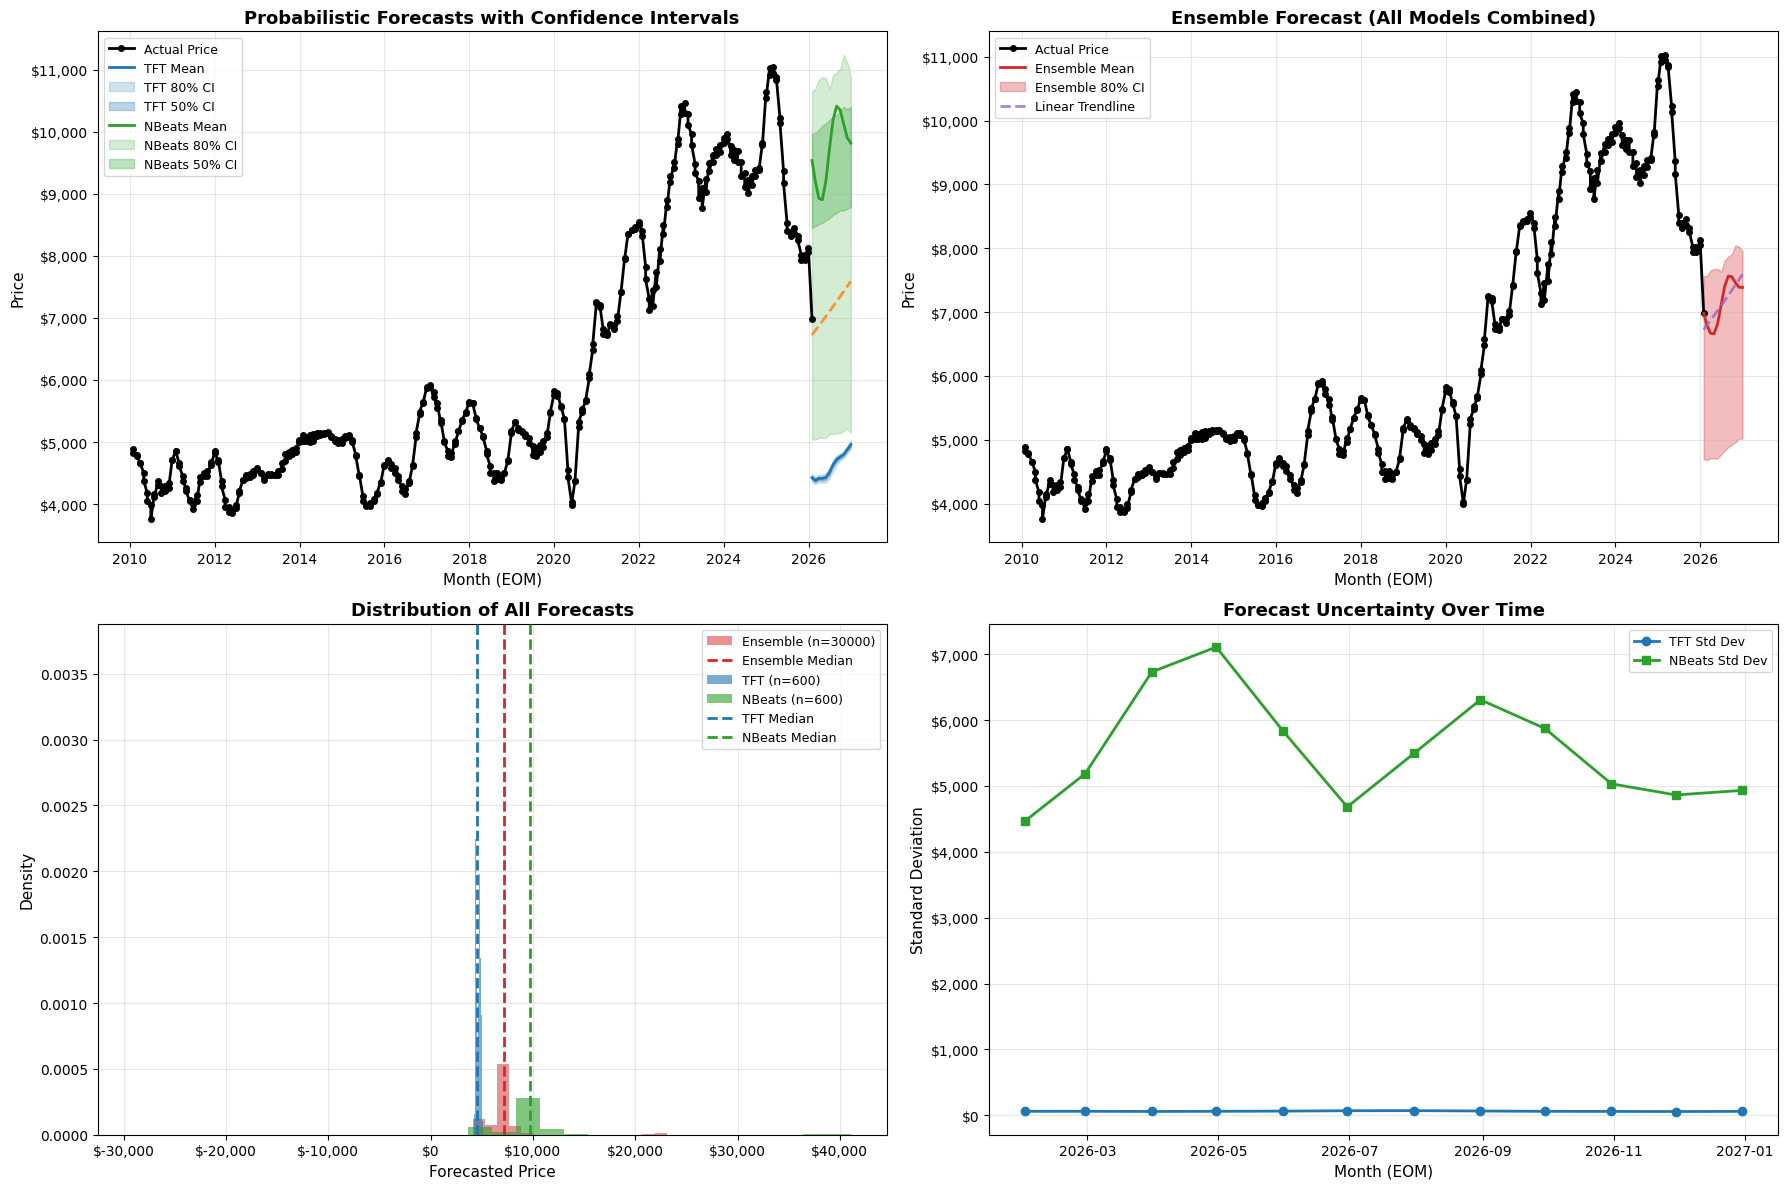


FORECAST SUMMARY STATISTICS

Total forecasts generated: 100
  - TFT forecasts: 50
  - NBeats forecasts: 50

TFT Forecast Statistics:
  Mean: $4,610.36
  Std: $207.65
  Min: $4,150.14
  Max: $5,083.96

NBeats Forecast Statistics:
  Mean: $9,690.28
  Std: $5,625.43
  Min: $-29,041.59
  Max: $41,071.93

Ensemble Forecast (Next 12 months):
  2026-01-31: $6,980.00
  2026-02-28: $6,793.72
  2026-03-31: $6,669.45
  2026-04-30: $6,658.90
  2026-05-31: $6,820.03
  2026-06-30: $7,113.56
  2026-07-31: $7,409.36
  2026-08-31: $7,565.82
  2026-09-30: $7,555.53
  2026-10-31: $7,459.87
  2026-11-30: $7,390.50
  2026-12-31: $7,387.10



In [6]:
# Comprehensive visualization of all grid search forecasts

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
from scipy import stats

# Prepare data for plotting
plot_df = combined[["eom", "price"]].set_index("eom").copy()

# Organize forecasts by model type and date
tft_forecasts = {}
nbeats_forecasts = {}

for result in all_results:
    dates = pd.to_datetime(result.dates)  # Convert string dates back to datetime
    forecast_values = np.array(result.forecast)  # Convert list back to numpy array
    
    if result.model_name == "TFT":
        for date, value in zip(dates, forecast_values):
            if date not in tft_forecasts:
                tft_forecasts[date] = []
            tft_forecasts[date].append(value)
    elif result.model_name == "NBeats":
        for date, value in zip(dates, forecast_values):
            if date not in nbeats_forecasts:
                nbeats_forecasts[date] = []
            nbeats_forecasts[date].append(value)

# Create forecast DataFrames with statistics
def create_forecast_df(forecasts_dict, model_name):
    """Create DataFrame with mean, percentiles from multiple forecasts"""
    dates = sorted(forecasts_dict.keys())
    data = {
        "eom": dates,
        f"{model_name}_mean": [],
        f"{model_name}_median": [],
        f"{model_name}_p10": [],
        f"{model_name}_p25": [],
        f"{model_name}_p75": [],
        f"{model_name}_p90": [],
        f"{model_name}_std": [],
    }
    
    for date in dates:
        values = np.array(forecasts_dict[date])
        data[f"{model_name}_mean"].append(np.mean(values))
        data[f"{model_name}_median"].append(np.median(values))
        data[f"{model_name}_p10"].append(np.percentile(values, 10))
        data[f"{model_name}_p25"].append(np.percentile(values, 25))
        data[f"{model_name}_p75"].append(np.percentile(values, 75))
        data[f"{model_name}_p90"].append(np.percentile(values, 90))
        data[f"{model_name}_std"].append(np.std(values))
    
    return pd.DataFrame(data).set_index("eom")

tft_forecast_df = create_forecast_df(tft_forecasts, "TFT")
nbeats_forecast_df = create_forecast_df(nbeats_forecasts, "NBeats")

# Combine all forecasts
all_forecast_df = pd.concat([tft_forecast_df, nbeats_forecast_df], axis=1)

# Merge with actual prices
plot_df = plot_df.join(all_forecast_df, how="outer").sort_index()

# Calculate ensemble forecast (average of all models)
plot_df["ensemble_mean"] = plot_df[["TFT_mean", "NBeats_mean"]].mean(axis=1)
plot_df["ensemble_p10"] = plot_df[["TFT_p10", "NBeats_p10"]].mean(axis=1)
plot_df["ensemble_p90"] = plot_df[["TFT_p90", "NBeats_p90"]].mean(axis=1)
plot_df.iloc[len(combined.index), plot_df.columns.get_loc("price")] = plot_df.iloc[len(combined.index), plot_df.columns.get_loc("ensemble_mean")]
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: All forecasts with confidence intervals
ax1 = axes[0, 0]
ax1.plot(plot_df.index, plot_df["price"], label="Actual Price", color="black", linewidth=2, marker="o", markersize=4)

# TFT forecasts with confidence intervals
if "TFT_mean" in plot_df.columns:
    ax1.plot(plot_df.index, plot_df["TFT_mean"], label="TFT Mean", color="tab:blue", linewidth=2)
    ax1.fill_between(plot_df.index, plot_df["TFT_p10"], plot_df["TFT_p90"], 
                     alpha=0.2, color="tab:blue", label="TFT 80% CI")
    ax1.fill_between(plot_df.index, plot_df["TFT_p25"], plot_df["TFT_p75"], 
                     alpha=0.3, color="tab:blue", label="TFT 50% CI")

# NBeats forecasts with confidence intervals
if "NBeats_mean" in plot_df.columns:
    ax1.plot(plot_df.index, plot_df["NBeats_mean"], label="NBeats Mean", color="tab:green", linewidth=2)
    ax1.fill_between(plot_df.index, plot_df["NBeats_p10"], plot_df["NBeats_p90"], 
                     alpha=0.2, color="tab:green", label="NBeats 80% CI")
    ax1.fill_between(plot_df.index, plot_df["NBeats_p25"], plot_df["NBeats_p75"], 
                     alpha=0.3, color="tab:green", label="NBeats 50% CI")

ax1.set_xlabel("Month (EOM)", fontsize=11)
ax1.set_ylabel("Price", fontsize=11)
ax1.set_title("Probabilistic Forecasts with Confidence Intervals", fontsize=13, fontweight="bold")
ax1.legend(loc="best", fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f"${x:,.0f}"))

# Plot 2: Ensemble forecast
ax2 = axes[0, 1]
ax2.plot(plot_df.index, plot_df["price"], label="Actual Price", color="black", linewidth=2, marker="o", markersize=4)
if "ensemble_mean" in plot_df.columns:
    ax2.plot(plot_df.index, plot_df["ensemble_mean"], label="Ensemble Mean", color="tab:red", linewidth=2)
    ax2.fill_between(plot_df.index, plot_df["ensemble_p10"], plot_df["ensemble_p90"], 
                     alpha=0.3, color="tab:red", label="Ensemble 80% CI")
    
    # Add exponential trendline to ensemble forecast
    # Get only forecast data (future dates)
    forecast_mask = plot_df.index > combined["eom"].max()
    ensemble_forecast_data = plot_df.loc[forecast_mask, "ensemble_mean"].dropna()
    
    if len(ensemble_forecast_data) > 1:
        # Convert dates to numeric for fitting (days since first forecast date)
        x_numeric = np.array([(d - ensemble_forecast_data.index[0]).days for d in ensemble_forecast_data.index])
        y_values = ensemble_forecast_data.values
        
        # Fit exponential curve: y = a * exp(b * x)
        # Using log transformation: log(y) = log(a) + b * x
        # Only fit if all values are positive
        if np.all(y_values > 0):
            log_y = np.log(y_values)
            # Fit linear regression on log-transformed data
            coeffs = np.polyfit(x_numeric, log_y, 1)
            a = np.exp(coeffs[1])  # intercept
            b = coeffs[0]  # slope
            
            # Generate trendline values
            x_trend = np.linspace(x_numeric.min(), x_numeric.max(), 100)
            y_trend = a * np.exp(b * x_trend)
            
            # Convert back to dates
            first_date = ensemble_forecast_data.index[0]
            trend_dates = [first_date + pd.Timedelta(days=int(x)) for x in x_trend]
            
            # Plot exponential trendline
            ax2.plot(trend_dates, y_trend, label="Linear Trendline", color="tab:purple", 
                    linewidth=2, linestyle="--", alpha=0.8)
            ax1.plot(trend_dates, y_trend, label="Linear Trendline", color="tab:orange", 
                    linewidth=2, linestyle="--", alpha=0.8)
    
ax2.set_xlabel("Month (EOM)", fontsize=11)
ax2.set_ylabel("Price", fontsize=11)
ax2.set_title("Ensemble Forecast (All Models Combined)", fontsize=13, fontweight="bold")
ax2.legend(loc="best", fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f"${x:,.0f}"))

# Plot 3: Forecast distribution by model
ax3 = axes[1, 0]
tft_all_forecasts = []
nbeats_all_forecasts = []
ensemble_all_forecasts = []

# Organize forecasts by date to calculate ensemble
forecasts_by_date = {}
for result in all_results:
    dates = pd.to_datetime(result.dates)
    forecast_values = np.array(result.forecast)
    
    for date, value in zip(dates, forecast_values):
        if date not in forecasts_by_date:
            forecasts_by_date[date] = {"TFT": [], "NBeats": []}
        forecasts_by_date[date][result.model_name].append(value)
    
    if result.model_name == "TFT":
        tft_all_forecasts.extend(result.forecast)
    elif result.model_name == "NBeats":
        nbeats_all_forecasts.extend(result.forecast)

# Calculate ensemble forecasts (average of TFT and NBeats for each date)
for date, forecasts in forecasts_by_date.items():
    tft_vals = forecasts.get("TFT", [])
    nbeats_vals = forecasts.get("NBeats", [])
    
    # For each combination of TFT and NBeats forecasts on the same date, calculate ensemble
    if tft_vals and nbeats_vals:
        for tft_val in tft_vals:
            for nbeats_val in nbeats_vals:
                ensemble_all_forecasts.append((tft_val + nbeats_val) / 2)

if tft_all_forecasts and nbeats_all_forecasts:
    # Plot ensemble first (at the back) in red
    if ensemble_all_forecasts:
        ax3.hist(ensemble_all_forecasts, bins=30, alpha=0.5, label=f"Ensemble (n={len(ensemble_all_forecasts)})", 
                color="tab:red", density=True, zorder=1)
        ax3.axvline(np.median(ensemble_all_forecasts), color="tab:red", linestyle="--", linewidth=2, 
                   label="Ensemble Median", zorder=4)
    
    # Plot TFT and NBeats on top
    ax3.hist(tft_all_forecasts, bins=30, alpha=0.6, label=f"TFT (n={len(tft_all_forecasts)})", 
            color="tab:blue", density=True, zorder=2)
    ax3.hist(nbeats_all_forecasts, bins=30, alpha=0.6, label=f"NBeats (n={len(nbeats_all_forecasts)})", 
            color="tab:green", density=True, zorder=3)
    ax3.axvline(np.median(tft_all_forecasts), color="tab:blue", linestyle="--", linewidth=2, 
               label="TFT Median", zorder=5)
    ax3.axvline(np.median(nbeats_all_forecasts), color="tab:green", linestyle="--", linewidth=2, 
               label="NBeats Median", zorder=6)
    ax3.set_xlabel("Forecasted Price", fontsize=11)
    ax3.set_ylabel("Density", fontsize=11)
    ax3.set_title("Distribution of All Forecasts", fontsize=13, fontweight="bold")
    ax3.legend(loc="best", fontsize=9)
    ax3.grid(True, alpha=0.3)
    ax3.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f"${x:,.0f}"))

# Plot 4: Forecast uncertainty over time
ax4 = axes[1, 1]
if "TFT_std" in plot_df.columns and "NBeats_std" in plot_df.columns:
    ax4.plot(plot_df.index, plot_df["TFT_std"], label="TFT Std Dev", color="tab:blue", linewidth=2, marker="o")
    ax4.plot(plot_df.index, plot_df["NBeats_std"], label="NBeats Std Dev", color="tab:green", linewidth=2, marker="s")
    ax4.set_xlabel("Month (EOM)", fontsize=11)
    ax4.set_ylabel("Standard Deviation", fontsize=11)
    ax4.set_title("Forecast Uncertainty Over Time", fontsize=13, fontweight="bold")
    ax4.legend(loc="best", fontsize=9)
    ax4.grid(True, alpha=0.3)
    ax4.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f"${x:,.0f}"))

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("FORECAST SUMMARY STATISTICS")
print("="*60)
print(f"\nTotal forecasts generated: {len(all_results)}")
print(f"  - TFT forecasts: {sum(1 for r in all_results if r.model_name == 'TFT')}")
print(f"  - NBeats forecasts: {sum(1 for r in all_results if r.model_name == 'NBeats')}")

if tft_all_forecasts:
    print(f"\nTFT Forecast Statistics:")
    print(f"  Mean: ${np.mean(tft_all_forecasts):,.2f}")
    print(f"  Std: ${np.std(tft_all_forecasts):,.2f}")
    print(f"  Min: ${np.min(tft_all_forecasts):,.2f}")
    print(f"  Max: ${np.max(tft_all_forecasts):,.2f}")

if nbeats_all_forecasts:
    print(f"\nNBeats Forecast Statistics:")
    print(f"  Mean: ${np.mean(nbeats_all_forecasts):,.2f}")
    print(f"  Std: ${np.std(nbeats_all_forecasts):,.2f}")
    print(f"  Min: ${np.min(nbeats_all_forecasts):,.2f}")
    print(f"  Max: ${np.max(nbeats_all_forecasts):,.2f}")

if "ensemble_mean" in plot_df.columns:
    print(f"\nEnsemble Forecast (Next 12 months):")
    ensemble_forecast = plot_df["ensemble_mean"].dropna()
    for date, value in ensemble_forecast.items():
        print(f"  {date.strftime('%Y-%m-%d')}: ${value:,.2f}")

print("\n" + "="*60)


In [7]:
# Updated: Sample 50 well-distributed configurations per model
# This replaces the section that generates all combinations

# Generate all combinations first
print("Generating all hyperparameter combinations...")
tft_configs_all = generate_config_combinations(tft_grid, TFTConfig)
nbeats_configs_all = generate_config_combinations(nbeats_grid, NBeatsConfig)

print(f"Total TFT combinations: {len(tft_configs_all)}")
print(f"Total NBeats combinations: {len(nbeats_configs_all)}")

# Sample 50 well-distributed configurations per model
import random
random.seed(42)  # For reproducibility

# Sample 50 configurations from each model (or all if less than 50)
tft_configs = random.sample(tft_configs_all, min(50, len(tft_configs_all))) if len(tft_configs_all) > 50 else tft_configs_all
nbeats_configs = random.sample(nbeats_configs_all, min(50, len(nbeats_configs_all))) if len(nbeats_configs_all) > 50 else nbeats_configs_all

print(f"\nSampled TFT configurations: {len(tft_configs)}")
print(f"Sampled NBeats configurations: {len(nbeats_configs)}")
print(f"Total configurations to test: {len(tft_configs) + len(nbeats_configs)}")

# Note: Comment out or remove the old "Generate all combinations" section in the previous cell
# and use the tft_configs and nbeats_configs variables defined here


Generating all hyperparameter combinations...
Total TFT combinations: 192
Total NBeats combinations: 192

Sampled TFT configurations: 50
Sampled NBeats configurations: 50
Total configurations to test: 100


In [8]:
# Create scenarios table combining all three forecasts into three scenarios

# Ensure ensemble_median exists (calculate if not present)
if "ensemble_median" not in plot_df.columns:
    if "TFT_median" in plot_df.columns and "NBeats_median" in plot_df.columns:
        plot_df["ensemble_median"] = plot_df[["TFT_median", "NBeats_median"]].mean(axis=1)

# Get forecast dates (future dates only, excluding historical)
forecast_dates = plot_df.index[plot_df.index > combined["eom"].max()].sort_values()

# Create scenarios table by combining all three forecasts
scenarios_data = []

for eom in forecast_dates:
    # Collect all optimistic values (p10) from all three forecasts
    optimistic_values = []
    # Collect median values for realistic calculation
    median_values = []
    # Collect all pessimistic values (p90) from all three forecasts
    pessimistic_values = []
    
    # TFT scenarios
    if "TFT_p10" in plot_df.columns and eom in plot_df.index:
        optimistic_values.append(plot_df.loc[eom, "TFT_p10"])
        median_values.append(plot_df.loc[eom, "TFT_median"] if "TFT_median" in plot_df.columns else plot_df.loc[eom, "TFT_mean"])
        pessimistic_values.append(plot_df.loc[eom, "TFT_p90"])
    
    # NBeats scenarios
    if "NBeats_p10" in plot_df.columns and eom in plot_df.index:
        optimistic_values.append(plot_df.loc[eom, "NBeats_p10"])
        median_values.append(plot_df.loc[eom, "NBeats_median"] if "NBeats_median" in plot_df.columns else plot_df.loc[eom, "NBeats_mean"])
        pessimistic_values.append(plot_df.loc[eom, "NBeats_p90"])
    
    # Ensemble scenarios
    if "ensemble_p10" in plot_df.columns and eom in plot_df.index:
        optimistic_values.append(plot_df.loc[eom, "ensemble_p10"])
        median_values.append(plot_df.loc[eom, "ensemble_median"] if "ensemble_median" in plot_df.columns else plot_df.loc[eom, "ensemble_mean"])
        pessimistic_values.append(plot_df.loc[eom, "ensemble_p90"])
    
    # Calculate combined scenarios
    # Realistic: average between p10 (optimistic) and median values
    realistic_combined = np.mean(optimistic_values + median_values) if (optimistic_values and median_values) else None
    
    row = {
        "EOM": eom.strftime("%Y-%m-%d"),
        "Optimistic": np.median(optimistic_values) if optimistic_values else None,
        "Realistic": realistic_combined,
        "Pessimistic": np.median(pessimistic_values) if pessimistic_values else None,
    }
    
    scenarios_data.append(row)

# Create DataFrame
scenarios_df = pd.DataFrame(scenarios_data)

# Format values as currency strings for display
def format_currency(value):
    if pd.isna(value) or value is None:
        return "N/A"
    return f"${value:,.2f}"

# Format the DataFrame columns as currency
scenarios_df["Optimistic"] = scenarios_df["Optimistic"].apply(format_currency)
scenarios_df["Realistic"] = scenarios_df["Realistic"].apply(format_currency)
scenarios_df["Pessimistic"] = scenarios_df["Pessimistic"].apply(format_currency)

# Rename columns for better display
scenarios_df.columns = [
    "EOM",
    "Pessimistic (p10 median)",
    "Realistic (avg of p10 & median)",
    "Optimistic (p90 median)",
]

# Generate HTML table using DataFrame.to_html()
html_table = scenarios_df.to_html(index=False, escape=False, classes="table table-striped table-bordered")

# Display the HTML table
from IPython.display import HTML
display(HTML(html_table))

# Also print the DataFrame for reference
print("\n" + "="*80)
print("FORECAST SCENARIOS TABLE (Combined from TFT, NBeats, and Ensemble)")
print("="*80)
print(scenarios_df.to_string(index=False))


EOM,Pessimistic (p10 median),Realistic (avg of p10 & median),Optimistic (p90 median)
2026-01-31,"$4,695.76","$5,823.78","$7,566.90"
2026-02-28,"$4,683.41","$5,809.80","$7,564.08"
2026-03-31,"$4,711.73","$5,843.88","$7,652.69"
2026-04-30,"$4,707.05","$5,857.60","$7,674.38"
2026-05-31,"$4,708.68","$5,877.81","$7,678.03"
2026-06-30,"$4,770.34","$5,938.62","$7,633.91"
2026-07-31,"$4,830.12","$6,021.99","$7,808.51"
2026-08-31,"$4,885.82","$6,080.85","$7,872.11"
2026-09-30,"$4,924.14","$6,114.40","$7,909.11"
2026-10-31,"$4,961.87","$6,151.89","$8,044.49"



FORECAST SCENARIOS TABLE (Combined from TFT, NBeats, and Ensemble)
       EOM Pessimistic (p10 median) Realistic (avg of p10 & median) Optimistic (p90 median)
2026-01-31                $4,695.76                       $5,823.78               $7,566.90
2026-02-28                $4,683.41                       $5,809.80               $7,564.08
2026-03-31                $4,711.73                       $5,843.88               $7,652.69
2026-04-30                $4,707.05                       $5,857.60               $7,674.38
2026-05-31                $4,708.68                       $5,877.81               $7,678.03
2026-06-30                $4,770.34                       $5,938.62               $7,633.91
2026-07-31                $4,830.12                       $6,021.99               $7,808.51
2026-08-31                $4,885.82                       $6,080.85               $7,872.11
2026-09-30                $4,924.14                       $6,114.40               $7,909.11
2026-10-31  